# 手部(Hands)偵測 - YOLOx2模型訓練與調整

這一篇文章則是要手把手地介紹使用[basic-yolo-keras](https://github.com/erhwenkuo/basic-yolo-keras)來將Darknet預訓練的模型進行再訓練與調整來偵測人的雙手 (Hands)。

![hand dataset](http://www.robots.ox.ac.uk/~vgg/data/hands/hand_dataset_files/Picture_1.png)

## basic-yolo-keras 專案說明
[basic-yolo-keras](https://github.com/experiencor/basic-yolo-keras)包含在Keras中使用Tensorflow後端的YOLOv2演算方的實現。它支持訓練YOLOv2網絡與不同的網絡結構，如MobileNet和InceptionV3。

本專案是修改[basic-yolo-keras](https://github.com/experiencor/basic-yolo-keras)專案來實現手部偵測應用。

### 需求
- [Keras](https://github.com/fchollet/keras)
- [Tensorflow](https://www.tensorflow.org/)
- [Numpy](http://www.numpy.org/)
- [h5py](http://www.h5py.org/) (For Keras model serialization.)
- [Pillow](https://pillow.readthedocs.io/) (For rendering test results.)
- [Python 3](https://www.python.org/)
- [pydot-ng](https://github.com/pydot/pydot-ng) (Optional for plotting model.)

### 安裝
```bash
git clone https://github.com/erhwenkuo/basic-yolo-keras.git
cd basic-yolo-keras

pip install numpy h5py pillow
pip install tensorflow-gpu  # CPU-only: conda install -c conda-forge tensorflow
pip install keras # Possibly older release: conda install keras
...
```

### 資料及說明

[hand Dataset](http://www.robots.ox.ac.uk/~vgg/data/hands/)這個手部資料集是由許多不同公開的image dataset匯集而成，總共有13050手部被標注。


|Filename|Description|Size|
|--------|-----------|----|
|[hand_dataset.tar.gz]|Complete hand dataset with the evaluation code.|238.9 MB|
|[training_dataset.tar.gz]|Training dataset images and annotations with supporting matlab code.|174.9 MB|
|[test_dataset.tar.gz]|Test dataset images and annotations with supporting matlab code.|26.9 MB|
|[validation_dataset.tar.gz]|Validation dataset images and annotations with supporting matlab code.|23.3 MB|
|[evaluation_code.tar.gz]|Evaluation code for 'bigger' hand instances in the test dataset.|13.8 MB|


資料集的網站: http://www.robots.ox.ac.uk/~vgg/data/hands/

[hand_dataset.tar.gz]: <http://www.robots.ox.ac.uk/~vgg/data/hands/downloads/hand_dataset.tar.gz>
[training_dataset.tar.gz]: <http://www.robots.ox.ac.uk/~vgg/data/hands/downloads/training_dataset.tar.gz>
[test_dataset.tar.gz]: <http://www.robots.ox.ac.uk/~vgg/data/hands/downloads/test_dataset.tar.gz>
[validation_dataset.tar.gz]: <http://www.robots.ox.ac.uk/~vgg/data/hands/downloads/validation_dataset.tar.gz>
[evaluation_code.tar.gz]: <http://www.robots.ox.ac.uk/~vgg/data/hands/downloads/evaluation_code.tar.gz>

### 專案的檔案路徑布局

1. 從[YOLO官方網站](http://pjreddie.com/darknet/yolo/)下載Darknet模型的設置檔與權重檔到專案根目錄。例如:使用MS COCO資料集訓練的預訓練模型
    * 下載[YOLOv2 608x608 設置檔(yolo.cfg)](https://github.com/pjreddie/darknet/blob/master/cfg/yolo.cfg)
    * 下載[YOLOv2 608x608 權重檔(yolo.weights)](https://pjreddie.com/media/files/yolo.weights)
2. 在`basic-yolo-keras`的目錄裡產生一個子目錄`data`
3. 從[hand dataset](http://www.robots.ox.ac.uk/~vgg/data/hands/)點擊[hand_dataset.tar.gz](http://www.robots.ox.ac.uk/~vgg/data/hands/downloads/hand_dataset.tar.gz)來下載 `hand_dataset.tar.gz`。
4. 解壓縮`hand_dataset.tar.gz`並放置在`detectiondata\data\`目錄底下。

最後你的目錄結構看起來向這樣：
```
basic-yolo-keras/
├── xxxx.ipynb
├── yolo.weights
├── backend.py
├── preprocessing.py
├── utils.py
├── font/
│   └── FiraMono-Medium.otf
├── yolo.weights
└── data/
    └── hands_dataset/
        ├── training_dataset/
        │   ├── training_data/     <--- 訓練圖像的位置
        │   ├── README.txt
        │   ├── displaydata.m
        │   └── counttraindata.m
        ├── validation_dataset/
        │   ├── validation_data/   <--- 驗證圖像的位置
        │   ├── README.txt
        │   ├── displaydata.m
        │   └── counttraindata.m
        └── test_dataset/
            ├── test_data/         <--- 測試圖像的位置
            ├── README.txt
            ├── displaydata.m
            └── counttraindata.m
```

### STEP1.載入相關函式庫

In [1]:
# Utilities相關函式庫
import os
import random
from glob import glob
from tqdm import tqdm  # 進度條

# 讀取.mat檔所使用函式庫
import scipy.io as sio

# 多為向量處理相關函式庫
import numpy as np

# 圖像處理相關函式庫
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# 序列/反序列化相關函式庫
import pickle

# 深度學習相關函式庫
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K

# 專案相關函式庫
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes, normalize
from utils import draw_bgr_image_boxes, draw_rgb_image_boxes, draw_pil_image_boxes

Using TensorFlow backend.


#### 設定相關設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 資料集目錄
DATA_SET_PATH = os.path.join(ROOT_DIR, 'data/hand_dataset')

# Training-資料目錄
TRAIN_SET_PATH = os.path.join(DATA_SET_PATH, 'training_dataset/training_data') 
TRAIN_ANNOTATIONS_PATH = os.path.join(TRAIN_SET_PATH, 'annotations') # Training-資料集標註檔目錄
TRAIN_IMAGES_PATH = os.path.join(TRAIN_SET_PATH, 'images') # Training-資料集圖像檔目錄

# Validation-資料目錄
VALID_SET_PATH = os.path.join(DATA_SET_PATH, 'validation_dataset/validation_data')
VALID_ANNOTATIONS_PATH = os.path.join(VALID_SET_PATH, 'annotations') # Validation-資料集標註檔目錄
VALID_IMAGES_PATH = os.path.join(VALID_SET_PATH, 'images') # Validation-資料集圖像檔目錄

# Test-資料目錄
TEST_SET_PATH = os.path.join(DATA_SET_PATH, 'test_dataset/test_data')
TEST_ANNOTATIONS_PATH = os.path.join(TEST_SET_PATH, 'annotations') # Validation-資料集標註檔目錄
TEST_IMAGES_PATH = os.path.join(TEST_SET_PATH, 'images') # Validation-資料集圖像檔目錄


# Tensorboard檔案目錄
LOGS_PATH = os.path.join(ROOT_DIR, 'logs')

# 檢查目錄始否存在
if not os.path.exists(LOGS_PATH):
    os.mkdir(LOGS_PATH)

#### 定義圖像的類別
在這個圖像資料及裡只有一種類別"hand"

In [3]:
# 圖像類別的Label-encoding
map_classes = {0: 'hand'}

# 取得所有圖像的圖像類別列表
labels = list(map_classes.values())

print(labels)

['hand']


**設定YOLOv2模型的設定與參數**

In [4]:
LABELS = labels # 圖像類別

IMAGE_H, IMAGE_W = 416, 416 # 模型輸入的圖像長寬
GRID_H,  GRID_W  = 13 , 13
BOX              = 6
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.5
NMS_THRESHOLD    = 0.45 # NMS非極大值抑制 , 說明(https://chenzomi12.github.io/2016/12/14/YOLO-nms/)
# ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
ANCHORS          = [0.3125, 0.3888, 0.3888, 0.3125, 0.9375, 1.125, 2.0833, 1.3888, 1.3888, 2.0833, 3.3333, 2.7777]
                 # [10, 14 , 14, 10, 30, 36, 75, 50, 50, 75, 120, 100]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

### STEP 2. 構建YOLOv2網絡結構模型

In [5]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [6]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [7]:
model.summary() # 打印模型

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

### STEP 3. 載入預訓練的模型權重

#### Darknet yolo weights, Training, Validation, Test File

In [8]:
dir_files = lambda image_path : [os.path.split(file.split('.')[0])[1] for file in glob(os.path.join(image_path,'*jpg'))]

wt_path = 'yolo.weights' 

train_files = dir_files(TRAIN_IMAGES_PATH)
valid_files = dir_files(VALID_IMAGES_PATH)
test_files = dir_files(TEST_IMAGES_PATH)

**Load the weights originally provided by YOLO**

In [9]:
weight_reader = WeightReader(wt_path)  # 初始讀取Darknet預訓練權重檔物件

In [10]:
weight_reader.reset()
nb_conv = 23 # 總共有23層的卷積層

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    # 在conv_1~conv_22的卷積組合裡都包含了"conv + norm"二層, 只有conv_23是獨立一層    
    if i < nb_conv: 
        print("handle norm_" + str(i) + " start")        
        norm_layer = model.get_layer('norm_' + str(i)) # 取得BatchNormalization層
        
        size = np.prod(norm_layer.get_weights()[0].shape) # 取得BatchNormalization層的參數量
        print("shape: ", norm_layer.get_weights()[0].shape)
        
        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma, beta, mean, var])
        print("handle norm_" + str(i) + " completed")
        
    if len(conv_layer.get_weights()) > 1:
        print("handle conv_" + str(i) + " start")  
        print("len:",len(conv_layer.get_weights()))
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
        print("handle conv_" + str(i) + " completed")
    else:
        print("handle conv_" + str(i) + " start")        
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])
        print("handle conv_" + str(i) + " completed")

handle norm_1 start
shape:  (32,)
handle norm_1 completed
handle conv_1 start
handle conv_1 completed
handle norm_2 start
shape:  (64,)
handle norm_2 completed
handle conv_2 start
handle conv_2 completed
handle norm_3 start
shape:  (128,)
handle norm_3 completed
handle conv_3 start
handle conv_3 completed
handle norm_4 start
shape:  (64,)
handle norm_4 completed
handle conv_4 start
handle conv_4 completed
handle norm_5 start
shape:  (128,)
handle norm_5 completed
handle conv_5 start
handle conv_5 completed
handle norm_6 start
shape:  (256,)
handle norm_6 completed
handle conv_6 start
handle conv_6 completed
handle norm_7 start
shape:  (128,)
handle norm_7 completed
handle conv_7 start
handle conv_7 completed
handle norm_8 start
shape:  (256,)
handle norm_8 completed
handle conv_8 start
handle conv_8 completed
handle norm_9 start
shape:  (512,)
handle norm_9 completed
handle conv_9 start
handle conv_9 completed
handle norm_10 start
shape:  (256,)
handle norm_10 completed
handle conv_10 

### STEP 4. 設定要微調(fine-tune)的模型層級權重

**Randomize weights of the last layer**

由於在YOLOv2的模型中, 最後一層卷積層決定了最後的輸出, 讓我們重新來調整與訓練這一層的卷積層來讓預訓練的模型可以讓我們進行所需要的微調。
詳細的概念與說明,見 [1.5: 使用預先訓練的卷積網絡模型](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.5-use-pretrained-model-2.ipynb)。

In [11]:
layer   = model.layers[-4] # 找出最後一層的卷積層
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias]) # 重初始化權重

### STEP 5. 模型訓練

**YOLOv2訓練用的損失函數:**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [12]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 6, 1]) ### 修改成6個anchor
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

**用來產生Keras訓練模型的BatchGenerator的設定:**

In [13]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, # YOLOv2網絡輸入的image_h
    'IMAGE_W'         : IMAGE_W, # YOLOv2網絡輸入的image_w
    'GRID_H'          : GRID_H,  # 直向網格的拆分數量
    'GRID_W'          : GRID_W,  # 橫向網格的拆分數量
    'BOX'             : BOX,     # 每個單一網格要預測的邊界框數量
    'LABELS'          : LABELS,  # 要預測的圖像種類列表
    'CLASS'           : len(LABELS), # 要預測的圖像種類數
    'ANCHORS'         : ANCHORS, # 每個單一網格要預測的邊界框時用的錨點
    'BATCH_SIZE'      : BATCH_SIZE, # 訓練時的批量數
    'TRUE_BOX_BUFFER' : 50, # 一個訓練圖像最大數量的邊界框數
}

**解析圖像標註檔**

由於這個資料的標註檔是使用Matlab檔案形式儲存，因此需要個至換函式讀取.mat檔裡的bouning box等訊息

In [14]:
def parse_hands_annotation(ann_dir, img_dir, files):
    all_imgs = []
    seen_labels = {'hand': 0}
    for file in files:
        # read the .mat file
        data = sio.loadmat(ann_dir + '/' + file + '.mat')
        box_count = data['boxes'].shape[1]
        boxes = []
        for count in range(box_count):
            box_shape = np.vstack((data['boxes'][0, count][0, 0][0], data['boxes'][0, count][0, 0][1],
                                   data['boxes'][0, count][0, 0][2], data['boxes'][0, count][0, 0][3]))
            ymax, xmax = box_shape.max(axis=0)
            ymin, xmin = box_shape.min(axis=0)
            box = {'name': 'hand', 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax}
            boxes.append(box)

        # read the image size
        file_path = img_dir + '/' + file + '.jpg'
        img = Image.open(file_path)
        width, height = img.size
        all_imgs.append({'filename': file_path, 'width': width, 'height': height, 'object':boxes})
        seen_labels['hand'] += box_count
    return all_imgs, seen_labels

In [15]:
# 進行圖像標註檔的解析 (在Racoon資料集的標註採用的是PASCAL VOC的XML格式)
train_imgs, seen_train_labels = parse_hands_annotation(TRAIN_ANNOTATIONS_PATH, TRAIN_IMAGES_PATH, train_files)

# 建立一個訓練用的資料產生器
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize, jitter=False)

# 進行圖像標註檔的解析 (在Racoon資料集的標註採用的是PASCAL VOC的XML格式)
valid_imgs, seen_valid_labels = parse_hands_annotation(VALID_ANNOTATIONS_PATH, VALID_IMAGES_PATH, valid_files)

# 建立一個驗證用的資料產生器
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

**設置一些回調函式並開始訓練**

In [16]:
# 如果超過3次的循環在loss的收歛上沒有改善就停止訓練 
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=15, 
                           mode='min', 
                           verbose=1)

# 每次的訓練循都去比較模型的loss是否有改善, 有就把模型的權重儲存下來
checkpoint = ModelCheckpoint('weights_hands.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

log_file_name = 'Hand_' + str(len(os.listdir(LOGS_PATH))+1)
tensorboard = TensorBoard(log_dir='./logs/' + log_file_name, 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

### STEP 6.圖像訓練

In [17]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

history = model.fit_generator(generator = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 200, # 應該增加更多次的訓練循環 
                    verbose          = 0,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)


Epoch 00001: val_loss improved from inf to 0.12923, saving model to weights_hands.h5

Epoch 00002: val_loss improved from 0.12923 to 0.09124, saving model to weights_hands.h5

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss improved from 0.09124 to 0.07856, saving model to weights_hands.h5

Epoch 00005: val_loss improved from 0.07856 to 0.07730, saving model to weights_hands.h5

Epoch 00006: val_loss improved from 0.07730 to 0.07415, saving model to weights_hands.h5

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss improved from 0.07415 to 0.07363, saving model to weights_hands.h5

Epoch 00018: val_loss did not impr

### STEP 7. 圖像的物體偵測

In [17]:
# 載入訓練好的模型權重
model.load_weights("weights_hands.h5")

In [18]:
# 產生一個Dummy的標籤輸入

# 在訓練階段放的是真實的邊界框與圖像類別訊息
# 但在預測階段還是需要有一個Dummy的輸入, 因為定義在網絡的結構中有兩個輸入： 
#   1.圖像的輸人 
#   2.圖像邊界框/錨點/信心分數的輸入
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

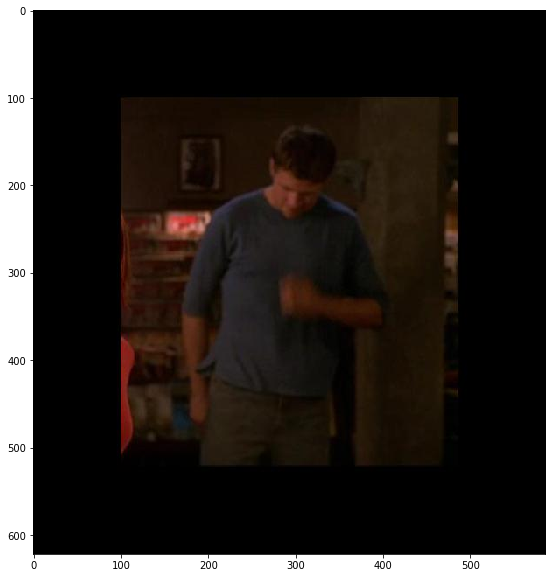

In [19]:
# 選一張圖像
# img_file = test_files[np.random.randint(len(test_files))]
# img_file_path = os.path.join(TEST_IMAGES_PATH, img_file) + '.jpg'
img_file_path = train_imgs[np.random.randint(len(train_imgs))]['filename']

# 使用OpenCV讀入圖像
image = cv2.imread(img_file_path) # 載入圖像

plt.figure(figsize=(10,10))

# 進行圖像輸入的前處理
input_image = cv2.resize(image, (416, 416)) # 修改輸入圖像大小來符合模型的要求
input_image = input_image / 255. # 進行圖像歸一處理
input_image = np.expand_dims(input_image, 0) # 增加 batch dimension

# 進行圖像偵測
netout = model.predict([input_image, dummy_array])

# 解析網絡的輸出來取得最後偵測出來的邊界框(bounding boxes)列表
boxes = decode_netout(netout[0], 
                      obj_threshold=0.3,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)

# "draw_bgr_image_boxes"
# 一個簡單把邊界框與預測結果打印到原始圖像(BGR)上的工具函式
# 參數: image 是image的numpy ndarray [h, w, channels(BGR)]
#       boxes 是偵測的結果
#       labels 是模型訓練的圖像類別列表
# 回傳： image 是image的numpy ndarray [h, w, channels(RGB)]
image = draw_bgr_image_boxes(image, boxes, labels=LABELS)

# 把最後的結果秀出來
plt.imshow(image)
plt.show()

### Training set 圖片框框分析

In [21]:
org_xmax = np.array([train_imgs[i]['object'][j]['xmax'] for i in range(len(train_imgs)) for j in range(len(train_imgs[i]['object']))])
org_xmin = np.array([train_imgs[i]['object'][j]['xmin'] for i in range(len(train_imgs)) for j in range(len(train_imgs[i]['object']))])
org_ymax = np.array([train_imgs[i]['object'][j]['ymax'] for i in range(len(train_imgs)) for j in range(len(train_imgs[i]['object']))])
org_ymin = np.array([train_imgs[i]['object'][j]['ymin'] for i in range(len(train_imgs)) for j in range(len(train_imgs[i]['object']))])

org_width = org_xmax - org_xmin
org_height = org_ymax - org_ymin

In [22]:
all_objs = []
for i in tqdm(train_imgs):
    image, objs = train_batch.aug_image(i, jitter=False)
    [all_objs.append(obj) for obj in objs]
    

100%|██████████| 4069/4069 [00:31<00:00, 127.50it/s]


In [23]:
xmax = np.array([all_objs[i]['xmax'] for i in range(len(all_objs))])
xmin = np.array([all_objs[i]['xmin'] for i in range(len(all_objs))])
ymax = np.array([all_objs[i]['ymax'] for i in range(len(all_objs))])
ymin = np.array([all_objs[i]['ymin'] for i in range(len(all_objs))])

width = xmax - xmin
height = ymax - ymin

(0, 330)

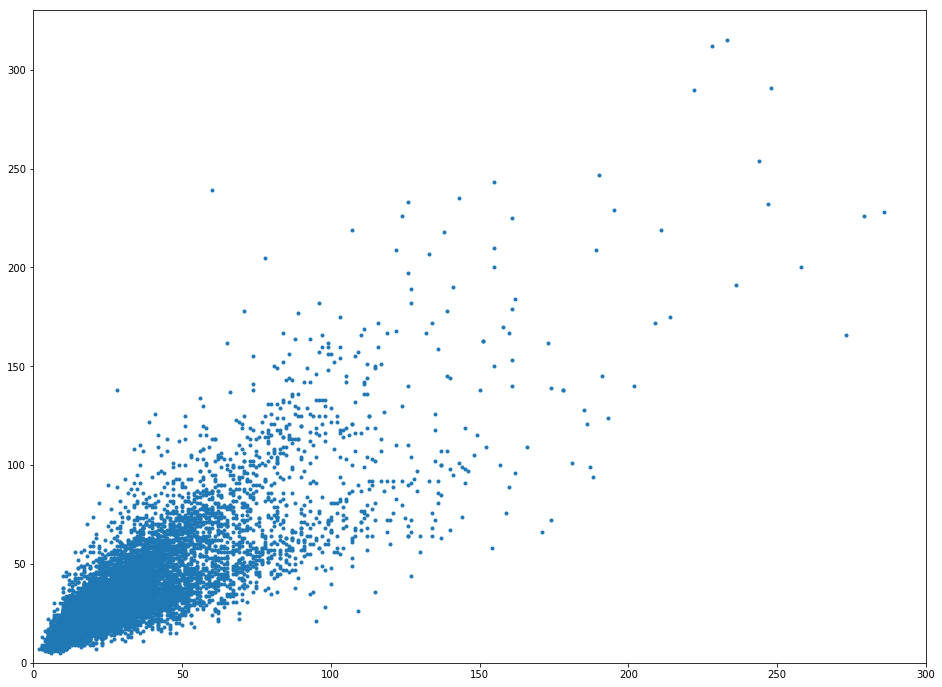

In [24]:
plt.figure(figsize=(16, 12))
plt.scatter(width, height, marker=".")
# plt.plot([0,75],[0,80], color="green")
# plt.plot([0,100],[0,60], color="green")
# plt.plot([0,50],[0,100], color="green")
plt.xlim(0,300)
plt.ylim(0,330)